# Bank Balance Forward Performance Demo

This notebook allows you to interact with the Bank Balance Forward demo, tweak variables, and generate performance metrics and charts.

In [6]:
import sys
import os

# Add the src directory to the Python path
src_dir = os.path.join(os.getcwd(), 'src')
sys.path.append(src_dir)

from datetime import UTC, datetime
import matplotlib.pyplot as plt
import numpy as np
from pymongo import MongoClient

from bbf_demo import bank_balance_forward, seed_database

## Setup MongoDB Connection

Adjust the connection string if your MongoDB is not running on localhost or uses a different port.

In [7]:
client = MongoClient('mongodb://localhost:27017')
db = client['items']

def clear_collections():
    db.ledger_line_items.drop()
    db.compressed_transactions.drop()
    db.archived_items.drop()

## Performance Testing Function

In [3]:
def run_test_and_measure(num_documents, compression_threshold, timeout=300):
    print(f"\nTesting with {num_documents} documents...")
    clear_collections()
    
    seed_start = datetime.now(UTC)
    seed_database(num_documents=num_documents, batch_size=5000)
    seed_end = datetime.now(UTC)
    print(f"Seeding completed in {(seed_end - seed_start).total_seconds():.2f} seconds")

    start_time = datetime.now(UTC)
    result = bank_balance_forward(compression_threshold)
    end_time = datetime.now(UTC)
    execution_time = (end_time - start_time).total_seconds()

    if execution_time > timeout:
        print(f"Test case for {num_documents} documents timed out after {timeout} seconds")
        return None

    return {
        'num_documents': num_documents,
        'execution_time': execution_time,
        'compressed_count': result['compressed_count'],
        'archived_count': result['archived_count'],
        'remaining_count': result['remaining_count']
    }

## Run Performance Tests

Adjust the test cases and timeout as needed.

In [9]:
test_cases = [
    (1000, 30),
    (10000, 30),
    (50000, 30),
    (100000, 30),
    (500000, 30),
    (1000000, 30)
]

results = []
for docs, threshold in test_cases:
    result = run_test_and_measure(docs, threshold, timeout=600)
    if result:
        results.append(result)
        print(f"Completed test case: {docs} documents in {result['execution_time']:.2f} seconds")
    else:
        print(f"Skipping remaining test cases due to timeout")
        break


Testing with 1000 documents...
Inserted 1000 documents
Data generation complete. Total documents: 1000
Seeding completed in 0.05 seconds
Completed test case: 1000 documents in 0.08 seconds

Testing with 10000 documents...
Inserted 5000 documents
Inserted 10000 documents
Data generation complete. Total documents: 10000
Seeding completed in 0.15 seconds
Completed test case: 10000 documents in 0.36 seconds

Testing with 50000 documents...
Inserted 5000 documents
Inserted 10000 documents
Inserted 15000 documents
Inserted 20000 documents
Inserted 25000 documents
Inserted 30000 documents
Inserted 35000 documents
Inserted 40000 documents
Inserted 45000 documents
Inserted 50000 documents
Data generation complete. Total documents: 50000
Seeding completed in 0.52 seconds
Completed test case: 50000 documents in 1.58 seconds

Testing with 100000 documents...
Inserted 5000 documents
Inserted 10000 documents
Inserted 15000 documents
Inserted 20000 documents
Inserted 25000 documents
Inserted 30000 d

## Generate Performance Chart

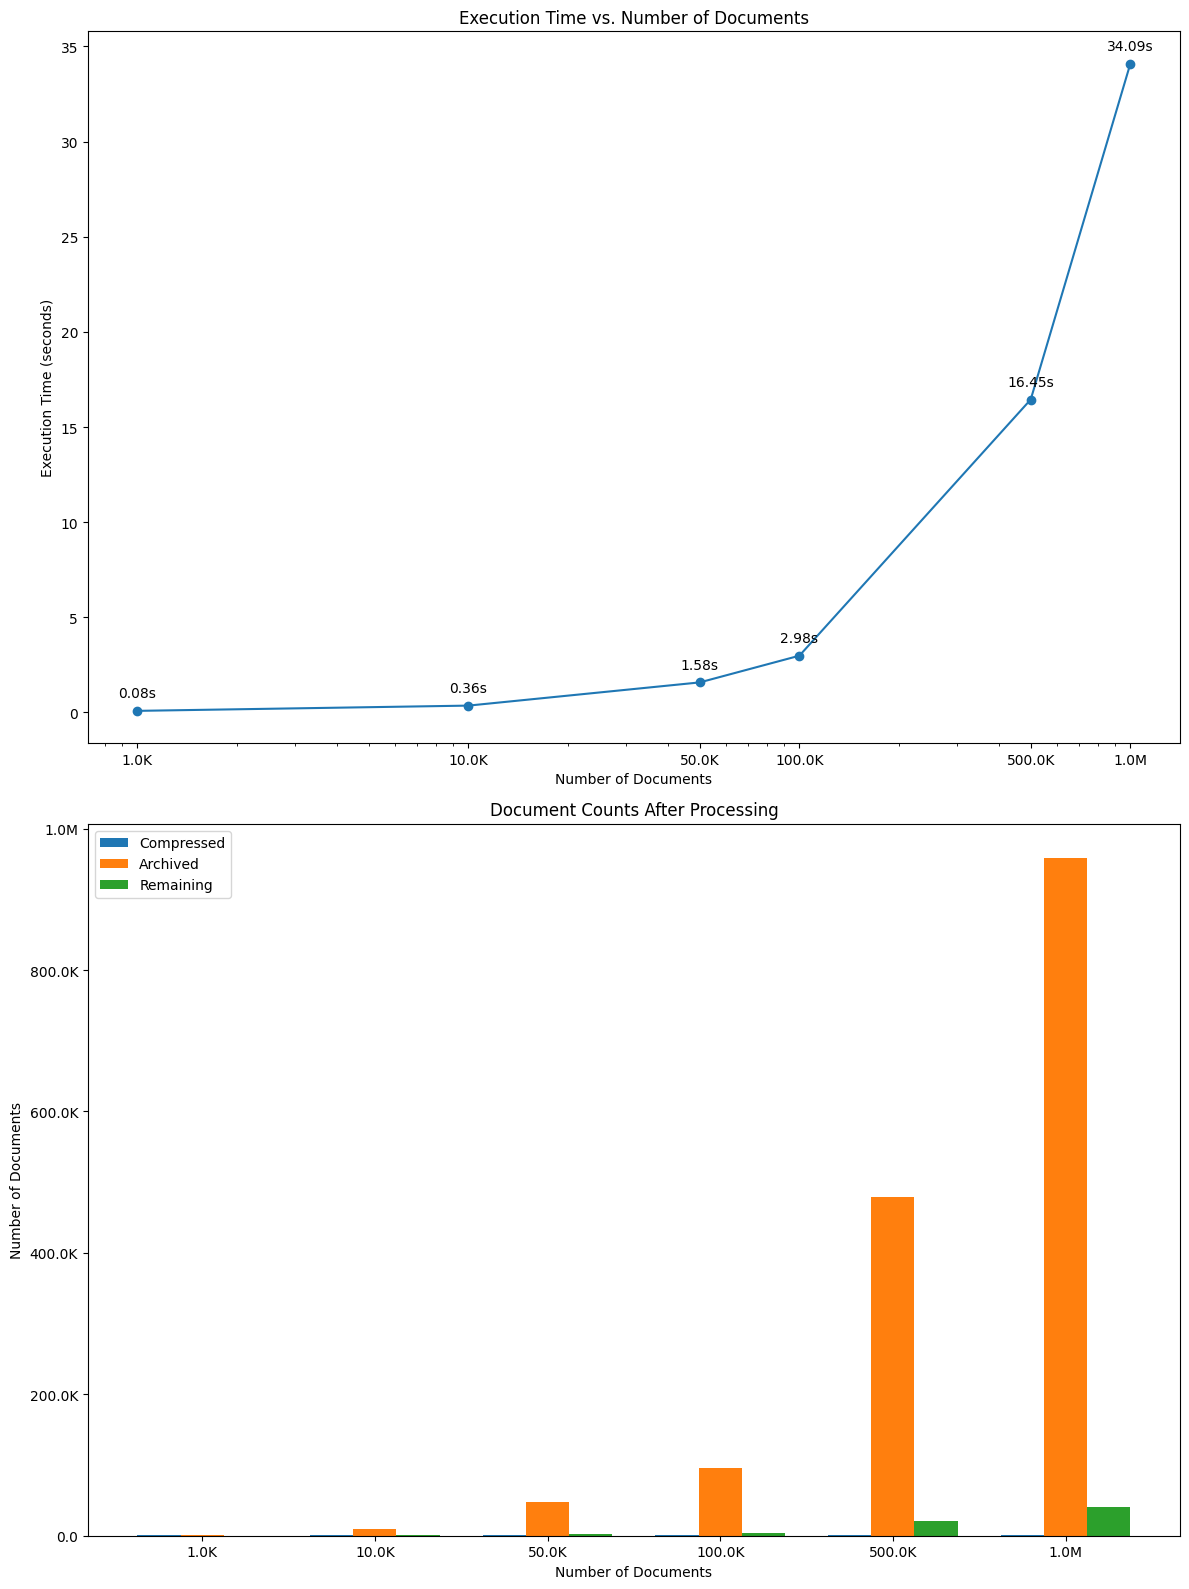

In [10]:
def format_number(num):
    """Format large numbers to be more readable with K, M, B suffixes."""
    if num >= 1_000_000_000:
        return f"{num/1_000_000_000:.1f}B"
    elif num >= 1_000_000:
        return f"{num/1_000_000:.1f}M"
    elif num >= 1_000:
        return f"{num/1_000:.1f}K"
    else:
        return str(num)

def generate_chart(results):
    doc_counts = [r['num_documents'] for r in results]
    execution_times = [r['execution_time'] for r in results]
    compressed_counts = [r['compressed_count'] for r in results]
    archived_counts = [r['archived_count'] for r in results]
    remaining_counts = [r['remaining_count'] for r in results]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

    # Execution Time Chart
    ax1.plot(doc_counts, execution_times, marker='o')
    ax1.set_xscale('log')
    ax1.set_xlabel('Number of Documents')
    ax1.set_ylabel('Execution Time (seconds)')
    ax1.set_title('Execution Time vs. Number of Documents')
    
    # Format x-axis labels
    ax1.set_xticks(doc_counts)
    ax1.set_xticklabels([format_number(count) for count in doc_counts])
    
    for i, txt in enumerate(execution_times):
        ax1.annotate(f"{txt:.2f}s", (doc_counts[i], execution_times[i]),
                     textcoords="offset points", xytext=(0, 10), ha='center')

    # Document Counts Chart
    width = 0.25
    x = np.arange(len(doc_counts))
    ax2.bar(x - width, compressed_counts, width, label='Compressed')
    ax2.bar(x, archived_counts, width, label='Archived')
    ax2.bar(x + width, remaining_counts, width, label='Remaining')
    ax2.set_xlabel('Number of Documents')
    ax2.set_ylabel('Number of Documents')
    ax2.set_title('Document Counts After Processing')
    ax2.set_xticks(x)
    
    # Format x-axis labels
    ax2.set_xticklabels([format_number(count) for count in doc_counts])
    
    ax2.legend()

    # Format y-axis labels for the second chart
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format_number(x)))

    plt.tight_layout()
    plt.show()

generate_chart(results)

## Custom Test Case

Use this cell to run a custom test case with your desired parameters.

In [ ]:
custom_docs = 50000  # Number of documents
custom_threshold = 45  # Compression threshold in days
custom_timeout = 300  # Timeout in seconds

custom_result = run_test_and_measure(custom_docs, custom_threshold, custom_timeout)
if custom_result:
    print(f"Custom test case results:")
    for key, value in custom_result.items():
        print(f"{key}: {value}")
else:
    print("Custom test case timed out")

## Cleanup

Run this cell to clean up the database after you're done testing.

In [ ]:
client.drop_database('items')
client.close()
print("Database cleaned up and connection closed.")